In [18]:
import os
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

#Sklearn imports(and othrs)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [66]:
#Load relevant data and create the full dataframe


filepath_met = "../linearmodel.parquet"

# read the Parquet file into a pandas dataframe
df = pq.read_pandas(filepath_met).to_pandas()

df.columns

Index(['Economically active: Employee: Full-time',
       'Economically active: Employee: Part-time',
       'Economically active: Full-time student',
       'Economically active: Self-employed with employees: Full-time',
       'Economically active: Self-employed with employees: Part-time',
       'Economically active: Self-employed without employees: Full-time',
       'Economically active: Self-employed without employees: Part-time',
       'Economically active: Unemployed',
       'Economically inactive: Long-term sick or disabled',
       'Economically inactive: Looking after home or family',
       'Economically inactive: Other', 'Economically inactive: Retired',
       'Economically inactive:  Full-time students', 'White British',
       'White Irish', 'White Gypsy/Irish Traveller', 'White Other',
       'Mixed White and Asian', 'Mixed White and Black African',
       'Mixed White and Black Caribbean', 'Mixed Other', 'Asian Bangladeshi',
       'Asian Chinese', 'Asian Indian', '

In [71]:

#Get the labels and features of the data
y = df['Crime ID_y']
X = df.drop(['Crime ID_y'], axis=1)


X_to_scale = X[['Economically active: Employee: Full-time',
       'Economically active: Employee: Part-time',
       'Economically active: Full-time student',
       'Economically active: Self-employed with employees: Full-time',
       'Economically active: Self-employed with employees: Part-time',
       'Economically active: Self-employed without employees: Full-time',
       'Economically active: Self-employed without employees: Part-time',
       'Economically active: Unemployed',
       'Economically inactive: Long-term sick or disabled',
       'Economically inactive: Looking after home or family',
       'Economically inactive: Other', 'Economically inactive: Retired',
       'Economically inactive:  Full-time students', 'White British',
       'White Irish', 'White Gypsy/Irish Traveller', 'White Other',
       'Mixed White and Asian', 'Mixed White and Black African',
       'Mixed White and Black Caribbean', 'Mixed Other', 'Asian Bangladeshi',
       'Asian Chinese', 'Asian Indian', 'Asian Pakistani', 'Asian Other',
       'Black African', 'Black Caribbean', 'Black Other', 'Other Arab',
       'Other Any other', 'Unnamed: 2', '1Months', '2Months',
       '3Months', '4Months', '5Months', '6Months', '7Months', '8Months',
       '9Months', '10Months', '11Months', '12Months']]

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_to_scale),columns = X_to_scale.columns)

X.update(X_scaled)

#Train/test split


X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,
                                               random_state=42, shuffle=True) 




In [31]:
#Linera regression for the crimes in a ward

reg = LinearRegression().fit(X_train, y_train)

predictions = reg.predict(X_test)


score = reg.score(X_test, y_test)
MAE = sum(abs(predictions - y_test))/len(predictions)
MSE = sum((predictions - y_test)**2)/len(predictions)

Text(0.5, 1.0, 'Feature coefficients')

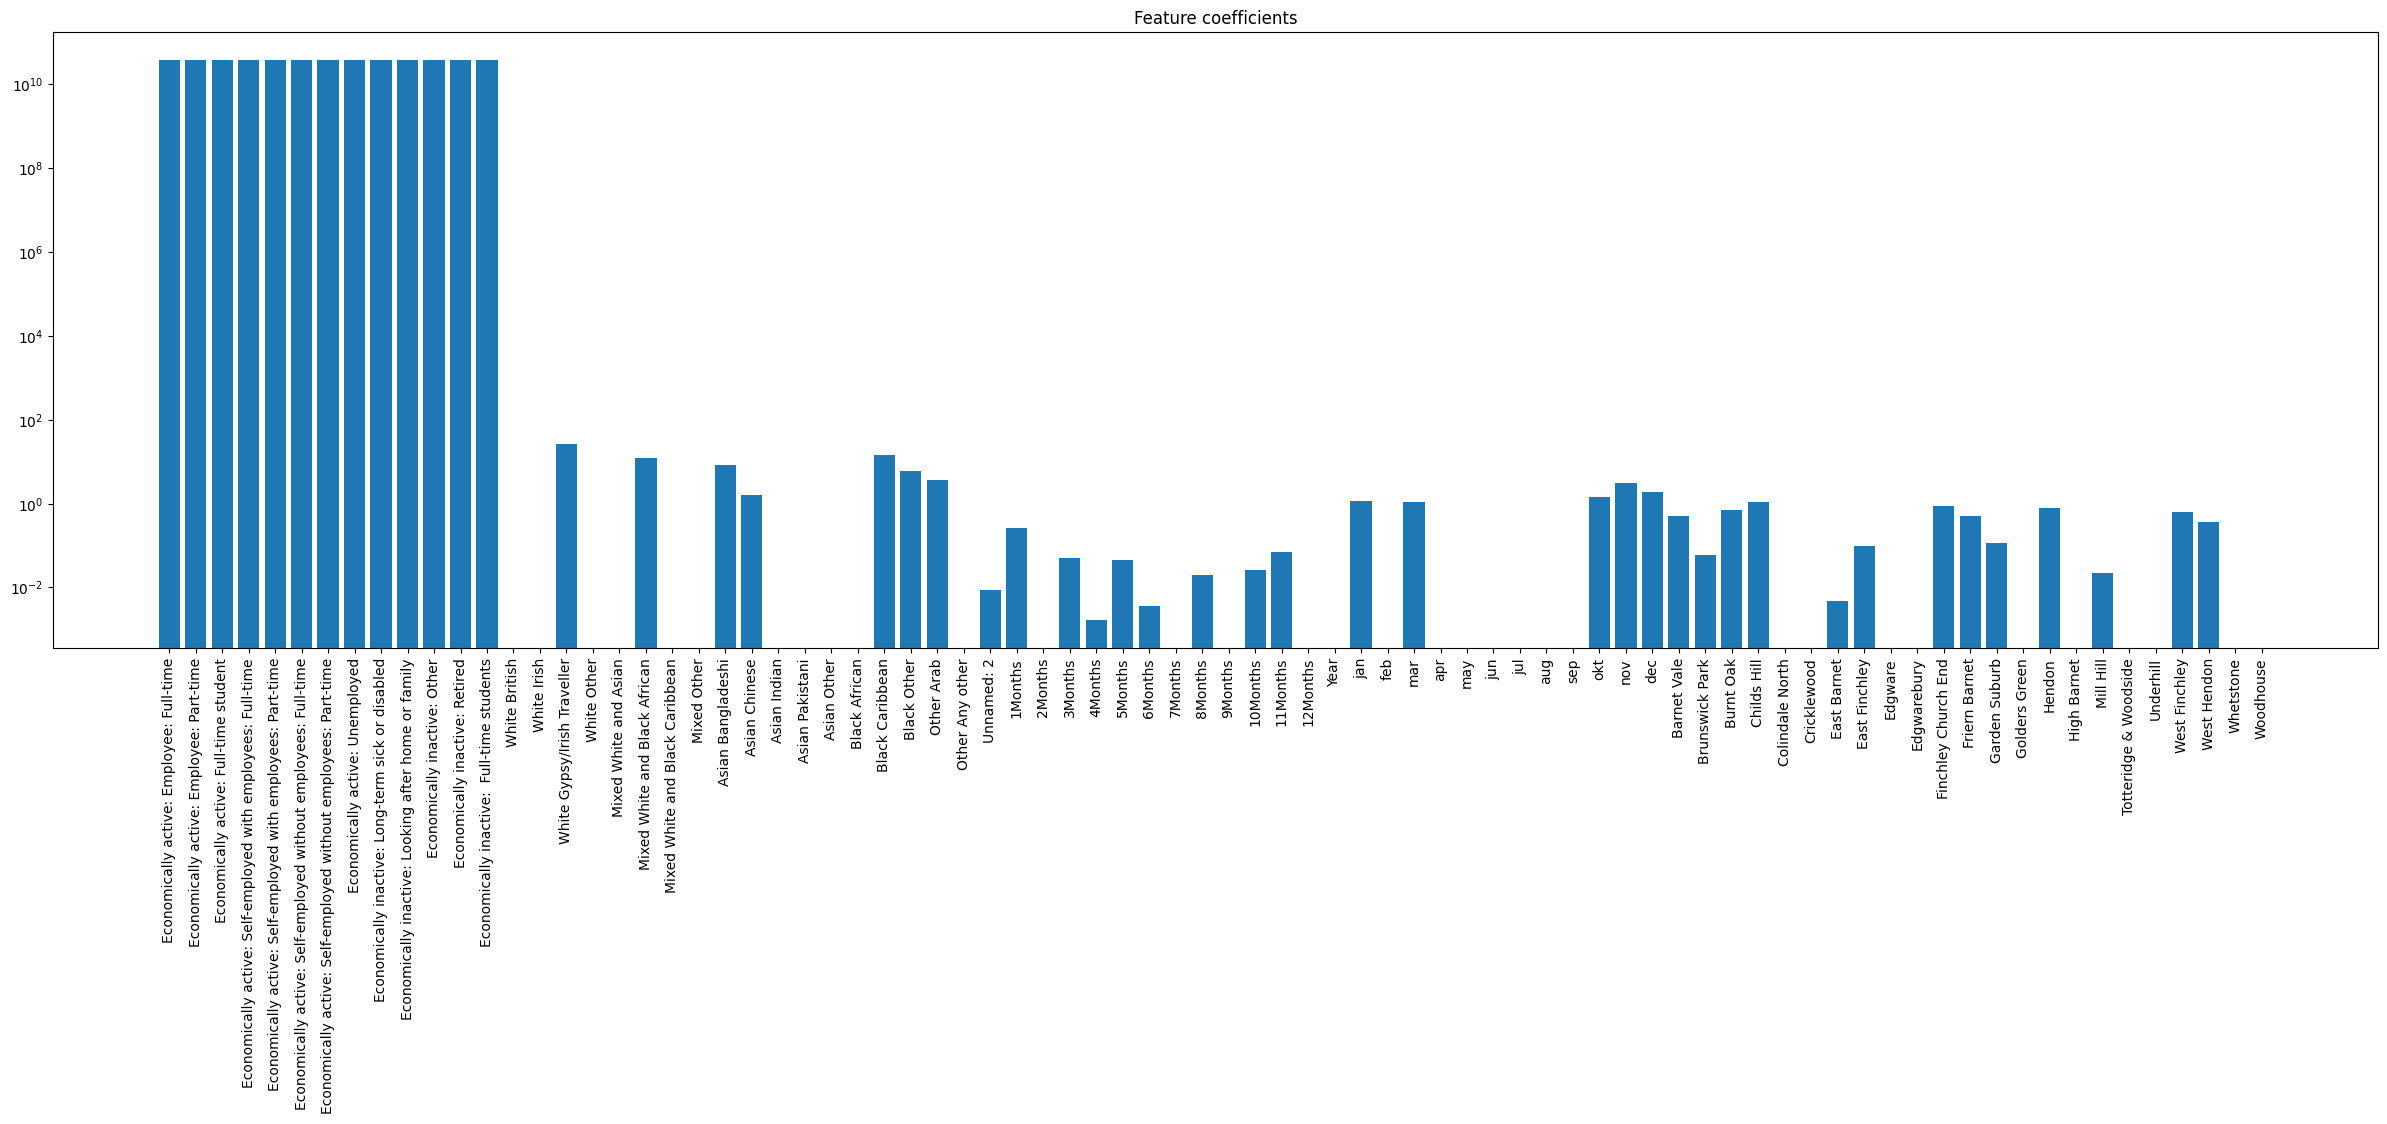

In [65]:
labels = df.columns
labels = labels.drop('Crime ID_y')

fig, ax = plt.subplots(figsize = (30,8))
ax.bar(x=np.arange(len(reg.coef_)), height = reg.coef_, log = True)
ax.set_xticks(np.arange(len(reg.coef_)))
ax.set_xticklabels(labels, rotation = 90)
ax.set_title('Feature coefficients')



Text(0.5, 1.0, 'Predicted mount of crimes per ward (R2=0.5503, MAE=4.3432, MSE=31.5485)')

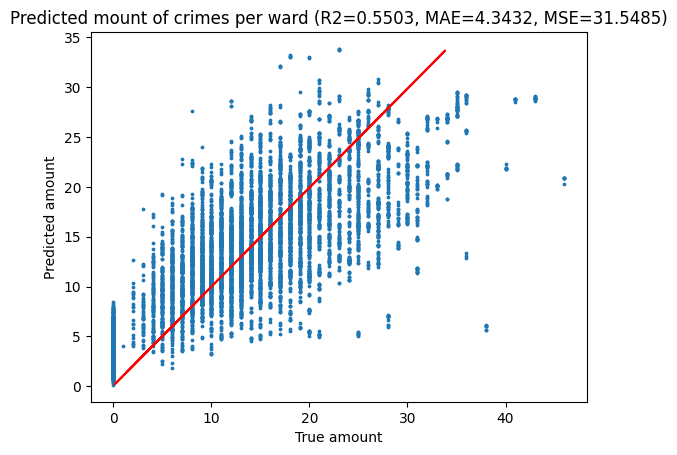

In [35]:
plt.scatter(y_test, predictions, s=3)

m, b = np.polyfit(predictions, y_test, 1)

plt.plot(predictions, m*predictions+b, c='r')

plt.xlabel('True amount')
plt.ylabel('Predicted amount')
plt.title(f'Predicted mount of crimes per ward (R2={score:.4f}, MAE={MAE:.4f}, MSE={MSE:.4f})')

Ideas:
-Binning for features
-Combining features
-clustering

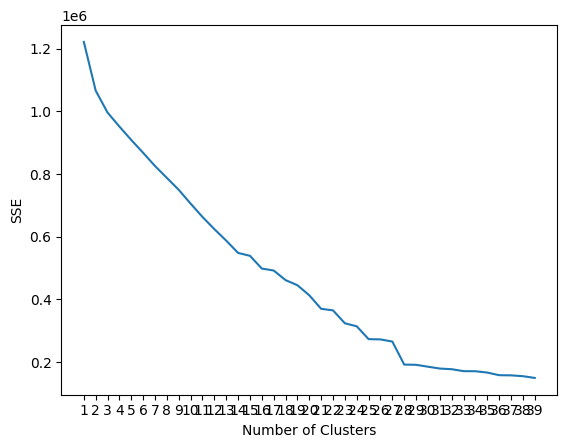

In [10]:
#Try to find clusters in the data
#The idea behind this is that there are hard to find patterns in the data and this way you can assign a burlary to similar ones

max_clusters = 40

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X),columns = X.columns)

#initialize kmeans parameters
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 1,
}

#create list to hold SSE values for each k
sse = []


for k in range(1, max_clusters):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

#visualize results
plt.plot(range(1, max_clusters), sse)
plt.xticks(range(1, max_clusters))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [20]:
#From the plot above we conclude that 30 clusters is the optimal amont of clusters

kmeans = KMeans(n_clusters=30, **kmeans_kwargs)
kmeans.fit(X_scaled)
results = kmeans.labels_


#Add clusters to the dataframe

merged_df['cluster'] = results


#Plot the clusters on the map
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

m_4 = folium.Map(location=[51.655067,-0.205163], tiles='cartodbpositron', zoom_start=13)
	

# Add a bubble map to the base map
for i in range(0,100):
    Circle(
        location=[merged_df.iloc[i]['Latitude'], merged_df.iloc[i]['Longitude']],
        radius=20,
        label=merged_df.iloc[i]['cluster']).add_to(m_4)

# Display the map
m_4

In [13]:
"""
#Random forest classifier(for predicting in which ward crimes will take place doesnt work anymore)

rfc = RandomForestClassifier(random_state = 42)

rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)
 
#Obtain accuracy

print("Test Score:",rfc.score(X_test,y_test))

conf_mat = confusion_matrix(y_test, y_pred)
#print(conf_mat)

import seaborn
import matplotlib.pyplot as plt
seaborn.heatmap(conf_mat)
plt.show()
"""

'\n#Random forest classifier(for predicting in which ward crimes will take place doesnt work anymore)\n\nrfc = RandomForestClassifier(random_state = 42)\n\nrfc.fit(X_train,y_train)\ny_pred = rfc.predict(X_test)\n \n#Obtain accuracy\n\nprint("Test Score:",rfc.score(X_test,y_test))\n\nconf_mat = confusion_matrix(y_test, y_pred)\n#print(conf_mat)\n\nimport seaborn\nimport matplotlib.pyplot as plt\nseaborn.heatmap(conf_mat)\nplt.show()\n'